## Exercise 5: Nonlinear optimization, camera calibration.


These exercises will take you through:
- checkerboard calibration, in real life with OpenCV.
- non-linear optimization, where you will implement a function non-linear triangulation


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy


### Nonlinear optimization

This exercise will take you through doing nonlinear optimization for triangulation of a single point. The same principles can be applied to more complex situations such as camera calibration, or situations where we lack a linear algoritm.

Construct two cameras with $R_1 = R_2 = I, t_1=\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}^T,  t_2=\begin{bmatrix} 0 & 0 & 20 \end{bmatrix}^T$ and 

$$ K_1=K_2=\begin{bmatrix} f & \beta f & \delta_x \\ 0 & \alpha f & \delta_y \\ 0 & 0 & 1 \end{bmatrix}=\begin{bmatrix} 700 & 0 & 600 \\ 0 & 700 & 400 \\ 0 & 0 & 1 \end{bmatrix}$$

The cameras both observe the same 3D point $Q =\begin{bmatrix} 1 & 1 & 0 \end{bmatrix}^T$.




- **Exercise 5.1**. What are the projection matrices $P_1$ and $P_2$ ?.
What is the projection of $Q$ in cameras one and two ($q_1$ and $q_2$) ?


In [2]:
#Camera matrix
K=np.array([[700,0,600],[0,700,400],[0,0,1]])
R=np.eye(3) #rotation
t1=np.transpose([0,0,1]) #translation
t2=np.transpose([0,0,20]) #translation
Cam1=np.column_stack((R,t1))
Cam2=np.column_stack((R,t2))

#Projection matrices
P1=K@Cam1
P2=K@Cam2
print('The projection matrix of Camera 1:')
print(np.round(P1,2))
print('\n')
print('The projection matrix of Camera 2:')
print(np.round(P2,2))

The projection matrix of Camera 1:
[[700.   0. 600. 600.]
 [  0. 700. 400. 400.]
 [  0.   0.   1.   1.]]


The projection matrix of Camera 2:
[[7.0e+02 0.0e+00 6.0e+02 1.2e+04]
 [0.0e+00 7.0e+02 4.0e+02 8.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 2.0e+01]]


In [3]:
def projectpoints(P,Q):
    [m,n]=np.shape(Q)
    cnt=np.ones(m)
    Q_ext=np.column_stack((Q,cnt))

    projection=P@Q_ext.T
    
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    
    q=np.column_stack((qx,qy))
    
    return q

In [4]:
Q=np.array([[1,1,0]])

q1=projectpoints(P1,Q)
q2=projectpoints(P2,Q)

print('The projection of Q in camera 1 is:',q1)

print('The projection of Q in camera 2 is:',q2)


The projection of Q in camera 1 is: [[1300. 1100.]]
The projection of Q in camera 2 is: [[635. 435.]]


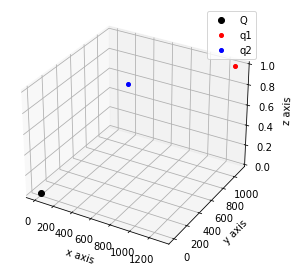

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

ax.plot(Q[0][0], Q[0][1],Q[0][2],'ko',markersize=6,label='Q')
ax.plot(q1[0][0], q1[0][1],1,'ro',markersize=4,label='q1')
ax.plot(q2[0][0], q2[0][1],1,'bo',markersize=4,label='q2')

plt.legend()
plt.show()

- **Exercise 5.2**.To simulate noise in the detection of points, we add errors to our projections.
$$q'_1 = q_1 +\begin{bmatrix} 1 & -1 \end{bmatrix}^T, q'_2 = q_2 + \begin{bmatrix} 1 & -1 \end{bmatrix}^T $$


Use your function `triangulate` from week 3 to triangulate $Q$ from $[q'_1,q'_2]$ and $[P_1, P_2]$.


Take the newly triangulated point $Q'$ and re-project it to the cameras. How far is it from our observations of the point ($q'_1$, $q'_2$)? 

In other words, what is the reprojection error for each camera? Is this as you expected when recalling the lecture from week 3?
How far is $Q'$ from $Q$?

In [6]:
def triangulate(qi,Pi):
    num=len(qi)
    B=[0,0,0,0]
    for a in range(num):
        x=qi[a][0][0]
        y=qi[a][0][1]
        P=Pi[a]
        #B is an array (2*n x 4), where n is the number of cameras
        Bi=np.array([P[2,:]*x-P[0,:],P[2,:]*y-P[1,:]])
        B=np.vstack([B, Bi])
        
    B=B[1:]
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    
    BQ=vh[-1,:] / vh[-1,-1]
    Q_tri=np.array([[BQ[0],BQ[1],BQ[2]]])
    
    return Q_tri

In [7]:
Pi=[P1,P2]
q1_noise=q1+np.array([1,-1])
q2_noise=q2+np.array([1,-1])
print(q1_noise)
print(q2_noise)
qi_noise=[q1_noise,q2_noise]

Q_tri=triangulate(qi_noise,Pi)

print('The newly triangulated point Q is:')
print('(',np.round(Q_tri[0][0],4),',',np.round(Q_tri[0][1],4),',',np.round(Q_tri[0][2],4),')')


[[1301. 1099.]]
[[636. 434.]]
The newly triangulated point Q is:
( 1.0153 , 0.9853 , 0.0003 )


In [8]:
#We reproject the new Q_tri into the cameras:
q1_tri=projectpoints(P1,Q_tri)
q2_tri=projectpoints(P2,Q_tri)
qi_tri=[q1_tri,q2_tri]

qi_tri

[array([[1310.48950027, 1089.4923513 ]]),
 array([[635.53411968, 434.4839772 ]])]

In [9]:
#ERRORS:
print(Q)
print(Q_tri)
#How far is Q from Q_tri
errorQ= (Q-Q_tri)**2
error_Q= np.sqrt(errorQ[0][0]+errorQ[0][1]+errorQ[0][2])
print('How far is Q_tri from Q:',error_Q)

#How far is q1 from q1_tri and q2 from q2_tri
error_q=[]
for i,a in enumerate(qi_tri):
    err=(qi_tri[i]-qi_noise[i])**2
    error_q.append(np.sqrt(err[0][0]+err[0][1]))
print('The reprojection error in camera 1 is:',error_q[0],'pixels.')
print('The reprojection error in camera 2 is:',error_q[1],'pixels.')



[[1 1 0]]
[[1.01527507e+00 9.85270570e-01 2.85786810e-04]]
How far is Q_tri from Q: 0.021221817353380967
The reprojection error in camera 1 is: 13.433018988192183 pixels.
The reprojection error in camera 2 is: 0.6717725840473774 pixels.


<font color='darkblue'> We expect the linear algorithm to place a larger weight on the error of camera 2 than camera 1, as it has a larger s. Therefore camera 2 having the smallest reprojection error is as we expected.

- **Exercise 5.3**.We are going to make a new function `triangulate_nonlin` that does triangulation using nonlinear optimization. It should take the same inputs as `triangulate`, i.e. a list of n pixel coordinates $(q_1, q_2, ..., q_n)$, and a list of n projection matrices $(P_1, P_2, ..., P_n)$.


Start by defining a helper-function inside triangulate_nonlin.
This function, called `compute_residuals`, should take the parameters we want to optimize (in this case $Q$) as input, and should returns a vector of residuals (i.e. the numbers that we want to minimize the sum of squares of). In this case the residuals are the differences in projection, i.e.

$$\begin{bmatrix} \pi(P_1Q) - q'_1 \\ ... \end{bmatrix}$$

Call `triangulate` inside your function to get an initial guess `x0` and use `scipy.optimize.least_squares(compute_residuals, x0)`
to do least squares optimization, starting from the initial guess of your linear algorithm.

In [10]:
# Takes a list of pixel coords and a list of projection matrices and returns the triangulation of the point using nonlinear optimization
def triangulate_nonlin(qi_noise, Pi):
    
    Q_triangulated = triangulate(qi_noise, Pi)
    Q_tri=np.array([Q_triangulated[0][0],Q_triangulated[0][1],Q_triangulated[0][2],1])
        
    # Computes the vector of residual of the parameters it takes
    def compute_residuals(Q):
        residuals = []
        for q, P in zip(qi_noise, Pi):
            residuals.append((P @ Q)[:-1] / (P @ Q)[-1] - q)

        return np.array(residuals).flatten()

    return scipy.optimize.least_squares(compute_residuals, Q_tri)


- **Exercise 5.4**. Use triangulate_nonlin with `[q ̃1, q ̃2]` and `[P 1, P 2]`. Let us call the nonlinearly estimated point `Qˆ `.
What is the reprojection error of `Qˆ` to camera 1 and 2? How far is `Qˆ` from `Q`?
Is this an improvement over the result in Exercise 5.2?

Congratulations! You now have a useful function that does not currently exist in OpenCV!

In [11]:
Q_tri_nonlin = triangulate_nonlin(qi_noise, Pi).x
Q_tri_nonlin = Q_tri_nonlin[:-1] / Q_tri_nonlin[-1]

print('(',np.round(Q_tri_nonlin[0],4),',',np.round(Q_tri_nonlin[1],4),',',np.round(Q_tri_nonlin[2],4),')')

#ERRORS:
#How far is Q from Q_tri
errorQ= (Q-Q_tri_nonlin)**2
error_Q= np.sqrt(errorQ[0][0]+errorQ[0][1]+errorQ[0][2])
print('How far is Q_tri from Q:',error_Q)


q1_tri_nonlin=P1@np.array([Q_tri_nonlin[0],Q_tri_nonlin[1],Q_tri_nonlin[2],1])
q2_tri_nonlin=P2@np.array([Q_tri_nonlin[0],Q_tri_nonlin[1],Q_tri_nonlin[2],1])

qi_tri_nonlin=[q1_tri_nonlin[:-1]/q1_tri_nonlin[-1],q2_tri_nonlin[:-1]/q2_tri_nonlin[-1]]

#How far is q1 from q1_tri and q2 from q2_tri
error_q=[]
for i,a in enumerate(qi_tri_nonlin):
    err=(qi_tri_nonlin[i]-qi_noise[i])**2
    error_q.append(np.sqrt(err[0][0]+err[0][1]))
print('The reprojection error in camera 1 is:',error_q[0],'pixels.')
print('The reprojection error in camera 2 is:',error_q[1],'pixels.')



( 1.0015 , 0.9985 , 0.0 )
How far is Q_tri from Q: 0.0021174153346841663
The reprojection error in camera 1 is: 0.06701023381488835 pixels.
The reprojection error in camera 2 is: 1.3401508686488992 pixels.


### Camera calibration with OpenCV

- **Exercise 5.5**. Take one of the provided calibration targets or print your own. If you do not have access to a printer, showing the target on a laptop or tablet display is also an option, albeit less ideal due to the glass on top of the display, which can cause reflection and refraction.

Using your calibration target, take pictures of it from many different angles. Make sure to have an image of it straight on and well lit, and try more extreme angles as well. Try to get every part of the frame covered. You should have around twenty images.


- **Exercise 5.6**. Transfer the images to your computer and load them into Python.
Take the image where the checkerboard is seen straight on and use `cv2.resize` to resize the image to 400 × 600.

Use the function `cv2.findChessboardCorners` to detect checkerboards in your images. Be aware that the function needs the number of internal corners on the checkerboard as input not the total size of the checkerboard. Use the small version of the image to figure out which combination of arguments wants as input (as the function for detecting corners takes a long time if it can’t find corners in a high resolution image).
Is the method able to detect checkerboards in all images? If you have a too extreme angle on some images, or there is too much of the checkerboard outside the frame, the detection function may fail. Use the images it was able to successfully detect checkerboards in, and continue to the next exercise.


In [12]:
# Load images
path = "checkboards/"
images = []
corners_found = []
corners_coords = []

for i in range(1,16):
    image = cv2.imread(path + str(i) + ".JPG")
    # Changing color channels from BGR to GRAY
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize to 400x600
    image = cv2.resize(image, (400, 600))
    images.append(image)
    
    # Check if the corners of the checkerboard (8x11) can be found   
    found, corners = cv2.findChessboardCorners(image, (7, 10), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    corners_found.append(found)
    corners_coords.append(corners)

print(corners_found)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


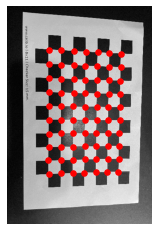

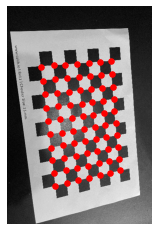

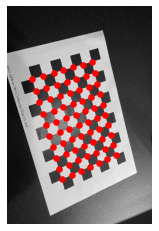

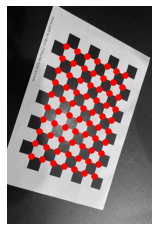

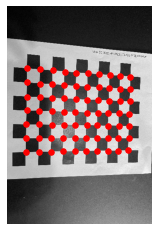

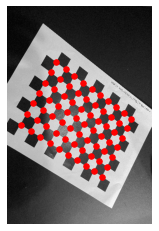

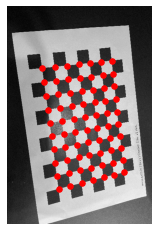

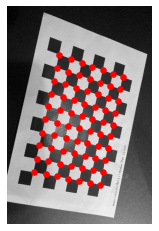

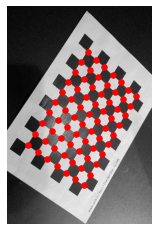

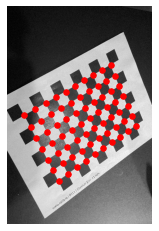

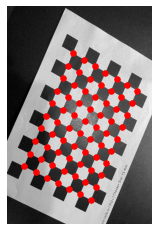

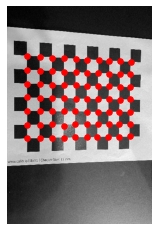

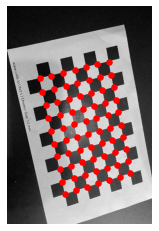

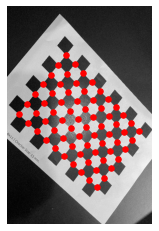

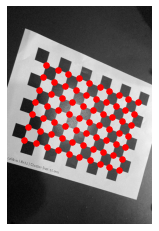

In [13]:
for i in range(len(images)):
    _, corners_img_straight = cv2.findChessboardCorners(images[i], (7, 10))

    plt.imshow(images[i], cmap="gray")
    plt.grid(False)
    plt.scatter(corners_img_straight[:,:,0], corners_img_straight[:,:,1], s=30, c="r")
    plt.axis('off')
    plt.show()

- **Exercise 5.7**. Now it’s time to calibrate the camera!
Use `checkerboard_points(n, m)` from last week to construct the points on the checkerboard
in 3D, and either use your own function `calibratecamera(qs, Q)` or the one from OpenCV `cv2.calibrateCamera` to calibrate the camera.

If you use the OpenCV function, make sure to set the flags argument to not have any lens distortion initially (feel free to add it later).

`flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST`
        
Inspect the `K` matrix. Is the principal point approximately in the center of your images?

(3, 70)


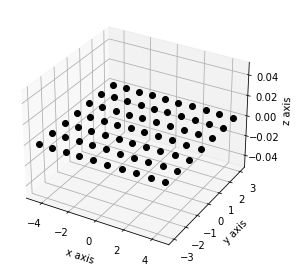

In [18]:
def checkerboard_points(n,m):
    M=np.array([[0],[0],[0]])
    for i in range(n):
        for j in range(m):
            Q=np.array([[i-((n-1)/2)],[j-((m-1)/2)],[0]])
            M=np.column_stack((M,Q))
    M=M[:,1:]
    
    return M #(3 x n·m)matrix

Q=checkerboard_points(10,7)
print(Q.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point1 in Q.T:
    ax.plot(point1[0], point1[1], point1[2], 'ko')

In [19]:
cb_2d_points = np.array(corners_coords)
cb_2d_points=cb_2d_points[:,:,0,:]
print(cb_2d_points.shape)

cb_3d_points=[]

for i in range(len(cb_2d_points)):
    cb_3d_points.append(checkerboard_points(10, 7).T)

cb_3d_points=np.array(cb_3d_points).astype(np.float32)
print(cb_3d_points.shape)

(15, 70, 2)
(15, 70, 3)


In [20]:
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(cb_3d_points, cb_2d_points, (400, 600), None, None, 
                                                 flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
                                                 cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)



[[396.7518   0.     201.8745]
 [  0.     446.631  303.5308]
 [  0.       0.       1.    ]]
201.8744948958569 303.5308091672642


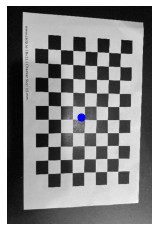

In [24]:
print(np.round(K,4))
delta_x = K[0][2]
delta_y = K[1][2]
print(delta_x,delta_y)


plt.imshow(images[0], cmap="gray")
plt.grid(False)
plt.scatter(delta_x, delta_y, s=50, c="b")
plt.axis('off')
plt.show()

- **Exercise 5.8**. Reproject the checkerboard corners to the images.
Tip: cv2.calibrateCamera returns rvecs, which are the R matrices stored in axis-angle representation. You can convert them to rotation matrices with cv2.Rodrigues.
Compute the reprojection error for each frame. Find the frame with the highest reprojection error and show both the detected and reprojected corner points. Hopefully you have an RMSE of a few pixels.

In [182]:
CamA=[]#camera matrix
P=[] #projection matrix
for rvec,t in zip(rvecs,tvecs):
    r, _ = cv2.Rodrigues(rvec)
    Cam=np.column_stack((r,t))
    CamA.append(Cam)
    P.append(K@Cam)

In [176]:
def projectpoints(P,Q):
    [m,n]=np.shape(Q)
    cnt=np.ones(m)
    Q_ext=np.column_stack((Q,cnt))

    projection=P@Q_ext.T
    
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    
    q_ijk=np.column_stack((qx,qy))
    
    return q_ijk



def projectionError(ori_q,esti_q):
    Err_x=0
    Err_y=0
    for a in range(len(esti_q)):
        Err_x=Err_x+((ori_q[a][0]-esti_q[a][0])**2)
        Err_y=Err_y+((ori_q[a][1]-esti_q[a][1])**2)
        
    Err=np.sqrt(Err_x+Err_y)
    
    return Err

In [194]:
qi_all=[]
E_all=[]
for i in range(len(cb_3d_points)):
    print('Image: ',i)
    qi=projectpoints(P[i],cb_3d_points[i])
    qi_all.append(qi)
    
    E=projectionError(cb_2d_points[i],qi)
    E_all.append(E)
    print(E)
    

Image:  0
4.108982043579773
Image:  1
4.742445664071187
Image:  2
4.278811251167388
Image:  3
4.231242258002488
Image:  4
4.011682595864941
Image:  5
3.5448923626705193
Image:  6
4.876467319529778
Image:  7
3.745594436504078
Image:  8
3.1807810085423136
Image:  9
3.906493568546822
Image:  10
4.3463640069104486
Image:  11
5.7667733015925595
Image:  12
3.6529336972818
Image:  13
3.243229518394325
Image:  14
3.4846780544500278


In [200]:
print('Highest reprojection error is:',np.max(E_all))
print('Highest reprojection error is in Image:',np.where(E_all==np.max(E_all))[0][0])

Highest reprojection error is: 5.7667733015925595
Highest reprojection error is in Image: 11


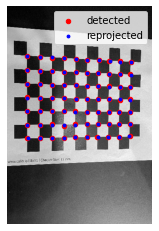

In [214]:
plt.imshow(images[11], cmap="gray")
plt.grid(False)
plt.scatter(cb_2d_points[11][:, 0], cb_2d_points[11][:, 1], s=20, c="r",label='detected')
plt.scatter(qi_all[11][:, 0], qi_all[11][:, 1], s=8, c="b",label='reprojected')
plt.axis('off')
plt.legend()
plt.show()

- **Exercise 5.9**. Try changing your distortion model to include k1 and k2. Do you get a lower reprojection error?
If your camera has visible lens distortion, try using the function from week 2 to undistort one of your images.